# Clustering Prototype - Initial Version
## Sentence embedding, dimensionality reduction, feature selection, clustering, and explaining clusters.

---

This file will allow you to set variables to run clustering and explainability on a dataset. In the next cell, you will be able to:

1.   Specify a dataset. The dataset must be in .csv format and must have at least one textual column to perform clustering on. If you wish to perform feature selection, the dataset must also have a categorical label column. The following datasets are already supported by this repo, but you can also upload your own dataset (instructions provided in next cell):
     - [IMDB Movie Reviews](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews)
     - [Customer Support Ticket Dataset](https://www.kaggle.com/datasets/suraj520/customer-support-ticket-dataset)
     - Synthetic Customer Data (synthetic conversations with customer support chatbot)
2.   Specify an embedding method. This file currently supports:
     - Sentence-BERT ([paper](https://arxiv.org/abs/1908.10084), [documentation](https://www.sbert.net/))
     - LLM2Vec ([paper](https://arxiv.org/abs/2404.05961), [GitHub](https://github.com/McGill-NLP/llm2vec))
2.   Flag if you would like dimensionality reduction (PCA) to occur
3.   Flag if you would like feature selection (decision trees) to occur

Based on these options, the file will run K-means clustering and labeling on the dataset.

Finally, it will print several data points close to each cluster centroid to help explain the cluster groupings.


## Set options for clustering

For each of the sections in the following cell, enable the option you wish to use (by uncommenting it) and ensure the other values are commented out. For any of the options, you can proceed with default values and later come back to modify them.

- For dataset selection:
  - Set the `dataset_sample_ratio` (the percentage of data the model will actually look at); for very large datasets, a fraction (few thousand rows) is a good benchmark
  - Uncomment the `dataset` you would like to use, and specify a `text_col` (the column name to perform clustering on)
  - If you wish to do feature selection (decision trees), specify a `label_col` as well (the column name to make predictions on)
  - Optionally: provide a custom dataset by uploading a `.csv` file in this repository, and set the `dataset`, `text_col` and optionally the `label_col` variables as described above

- For embedding methods, the options are:
  - Sentence BERT
  - LLM2Vec (note that this option may not work well on your machine due to it requiring large amounts of device memory)

- For dimensionality reduction, you can:
  - Enable `pca` and provide a number of dimensions for PCA
  - Or, disable `pca` by commenting it out

- For feature selection, you can:
  - Enable `decision_trees` and provide a `feature_importance_threshold`  (minimum importance threshold for selection) as well as a `test_train_ratio` (for training decision trees); feel free to proceed with our default values for these
  - Or, disable `decision_trees` by commenting it out

- For cluster count, you can specify:
  - A method to determine number of clusters for k-means (WCSS Elbow or Silhouette Score)

- For printing data points from each cluster centroid at the end, you can specify:
  - The number of points you would like to display from each cluster

In [1]:
# Dataset selection -----------------------------------
dataset_sample_ratio = 0.05 # percentage of dataset to actually look at

# --- IMDB movie reviews // 50k observations ---
dataset = "IMDB.csv"
text_col = "review"
label_col = "sentiment"

# --- Customer support tickets // ~600 observations ---
# dataset = "helpdesk_customer_tickets.csv"
# text_col = "answer"
# label_col = "priority"

# --- Synthetic customer support conversation with chatbot // ~500 observations ---
# dataset = "Synthetic_Customer_Data.csv"
# text_col = "Conversation"


# Embedding method -----------------------------------
method = "s_bert"
# method = "llm2vec"

# Dimensionality reduction (PCA) ---------------------
# pca = False
pca = True
pca_dimensions = 10

# Feature selection (decision trees)  ----------------
# decision_trees = False
decision_trees = True
feature_importance_threshold  = 0.025  # minimum importance threshold for selection
test_train_ratio = 0.3  # ratio for training decision trees

# Method to determine number of clusters for k-means --
num_clusters_method = "WCSS Elbow"
# num_clusters_method = "Silhouette Score"

# Num example data points to print per cluster ---------
example_count = 5

## Imports and Requirements

In [ ]:
# This cell will pip install all necessary packages for this file

%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '#DO'

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\Kerria\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
# This cell imports all necessary libraries for this file

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer, util
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

!env PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True  # allow torch to allocate memory more effectively

c:\Users\shiva\anaconda3\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
c:\Users\shiva\anaconda3\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\Users\shiva\anaconda3\lib\site-packages\torchvi

### LLM2Vec additional requirement: Request model access

If you plan to use LLM2Vec, you need to create a HuggingFace account and [access token](https://huggingface.co/settings/tokens) (a read-level token should suffice). Then, request access to to the model [Mistral-7B-Instruct-v0.2](https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.2), which is currently under gated repo access, by clicking the button on the linked webpage. The request should be approved within seconds.

Run the following cell, and when prompted, paste in your access token.

In [ ]:
if method == "llm2vec":
  !pip install llm2vec -q
  !huggingface-cli login

  from llm2vec import LLM2Vec
  import torch
  from transformers import AutoTokenizer, AutoModel, AutoConfig
  from peft import PeftModel

## Clustering pipeline

Now that all the options are set, you can simply run all following cells. After the PCA and K-means graphs are generated, you can examine them to optionally manually set a number of dimensions for PCA, and/or manually set the number of clusters for K-means.

In [3]:
# Read dataset --------------------------------------------------------------
df = pd.read_csv(dataset)
df = df.sample(frac=dataset_sample_ratio)
text = df[text_col]

In [ ]:
# Calculate embeddings ------------------------------------------------------
# Note: this can be a time-consuming step depending on the dataset's size

if method == "s_bert":
  embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
  embeddings = embedding_model.encode(text.tolist(), convert_to_tensor=False)

elif method == "llm2vec":
  # Following code adapted from https://huggingface.co/McGill-NLP/LLM2Vec-Mistral-7B-Instruct-v2-mntp-supervised
  tokenizer = AutoTokenizer.from_pretrained(
      "McGill-NLP/LLM2Vec-Mistral-7B-Instruct-v2-mntp"
  )
  config = AutoConfig.from_pretrained(
      "McGill-NLP/LLM2Vec-Mistral-7B-Instruct-v2-mntp", trust_remote_code=True
  )
  model = AutoModel.from_pretrained(
      "McGill-NLP/LLM2Vec-Mistral-7B-Instruct-v2-mntp",
      trust_remote_code=True,
      config=config,
      torch_dtype=torch.bfloat16,
      device_map="cuda" if torch.cuda.is_available() else "cpu",
  )
  model = PeftModel.from_pretrained(
      model,
      "McGill-NLP/LLM2Vec-Mistral-7B-Instruct-v2-mntp",
  )
  model = model.merge_and_unload()  # This can take several minutes on CPU

  # Loading supervised model. This loads the trained LoRA weights on top of MNTP model. Hence the final weights are -- Base model + MNTP (LoRA) + supervised (LoRA).
  model = PeftModel.from_pretrained(
      model, "McGill-NLP/LLM2Vec-Mistral-7B-Instruct-v2-mntp-supervised"
  )

  # Wrapper for encoding and pooling operations
  l2v = LLM2Vec(model, tokenizer, pooling_mode="mean", max_length=512)

  embeddings = l2v.encode(text.tolist())

### PCA
If PCA is enabled, we will display a scree plot to examine how much of the variance can be explained by each dimension.

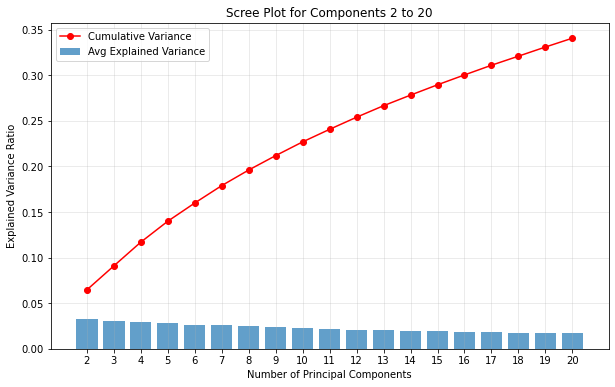

In [5]:
# Dimensionality Reduction (PCA) --------------------------------------------

# Create scree plot of possible number of components / dimensions
if pca:
  PCA_MAX_DIMENSION = 21
  n_components = range(2, PCA_MAX_DIMENSION) # range of testing

  # Perform PCA for each number of components and store explained variance
  explained_variance_ratios = []
  cumulative_variance_ratios = []

  for n in n_components:
      pca = PCA(n_components=n)
      pca.fit(embeddings)
      explained_variance_ratios.append(pca.explained_variance_ratio_)
      cumulative_variance_ratios.append(np.cumsum(pca.explained_variance_ratio_))

  # Average explained variance ratio over the number of components
  avg_explained_variance_ratio = [np.mean(ratio) for ratio in explained_variance_ratios]

  # Plot the scree plot
  plt.figure(figsize=(10, 6))
  plt.bar(n_components, avg_explained_variance_ratio, alpha=0.7, label='Avg Explained Variance')
  plt.plot(n_components, [cum[-1] for cum in cumulative_variance_ratios], label='Cumulative Variance', color='red', marker='o')

  # Add titles and labels
  plt.title('Scree Plot for Components 2 to 20')
  plt.xlabel('Number of Principal Components')
  plt.ylabel('Explained Variance Ratio')
  plt.xticks(n_components)
  plt.legend(loc='best')
  plt.grid(alpha=0.3)
  plt.show()

 Optionally, you can examine this plot and manually reset the `pca_dimension` number in the next cell. The optimal number of dimensions is the "elbow point" of the graph, where additional components contribute less to explained variance.

In [6]:
# OPTIONAL: In the next line, manually enter a new number of pca_dimensions to use based on the plot
# Else, we default to the number set at the beginning of the file
pca_dimensions = pca_dimensions

In [7]:
# Run PCA
if pca:
  pca_model = PCA(n_components=pca_dimensions)
  embeddings = pca_model.fit_transform(embeddings)

### Incorporate feature selection using decision trees

Recall that feature selection requires your dataset to have a `label_col`, which you can set at the very beginning. Feature selection will "shrink" or drop the non-important features with respect to the output class (or `label_col`), and "expand" the features that are more important to determining this output class.

In [ ]:
# Feature Selection (Decision Trees) ----------------------------------------
if decision_trees:
  X_train, X_test, y_train, y_test = train_test_split(embeddings, df[label_col], random_state = 8, test_size = test_train_ratio)

  # Fit the decision tree model
  decision_tree_model = DecisionTreeClassifier()
  decision_tree_model.fit(X_train, y_train)

  # Access feature importances
  feature_importances = decision_tree_model.feature_importances_

  # Delete low-importance features
  low_importance_indices = np.where(feature_importances < feature_importance_threshold)[0] # random sampling prob. -- 1/384 = 0.0026
  embeddings_small = np.delete(embeddings, low_importance_indices, axis=1)
  X_train_reduced = np.delete(X_train, low_importance_indices, axis=1)
  X_test_reduced = np.delete(X_test, low_importance_indices, axis=1)
  print(f"Embeddings went from size {len(X_train[0])} to {len(X_train_reduced[0])}")
  
else:
  embeddings_small = embeddings  # regardless of whether feature selection is performed, the next section uses embeddings_small

### K-means clustering

First, we will calculate and plot WCCS (within-cluster sum of squares) and silhouette scores for a range of `k` values, where `k` is the number of clusters used to fit the data.

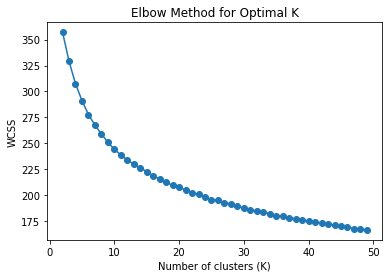

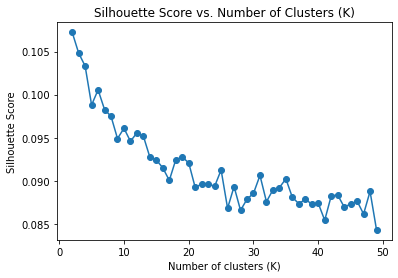

In [9]:
wcss_list = []  # within-cluster sum of squares
silhouette_scores_list = []

# Calculate WCSS and silhouette scores for each k
upper_bound_k = 50
for k in range(2, min(upper_bound_k, embeddings_small.shape[0])):
    # WCSS
    kmeans_experiment = KMeans(n_clusters=k, random_state=0)
    kmeans_experiment.fit(embeddings_small)
    wcss_list.append(kmeans_experiment.inertia_)

    # silhouette scores
    labels = kmeans_experiment.fit_predict(embeddings_small)
    score = silhouette_score(embeddings_small, labels)
    silhouette_scores_list.append(score)

# Plot WCSS values
plt.plot(range(2, min(upper_bound_k, embeddings_small.shape[0])), wcss_list, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('WCSS')
plt.show()

# Plot silhouette scores
plt.plot(range(2, min(upper_bound_k, embeddings_small.shape[0])), silhouette_scores_list, marker='o')
plt.title('Silhouette Score vs. Number of Clusters (K)')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette Score')
plt.show()

Based on the method to choose `k` selected at the beginning, the following cell will automatically calculate an appropriate `k` to use to run k-means clustering on the dataset.

Optionally: you can examine the graphs and manually choose the optimal value for `k` at the top of the next cell. This would be the "elbow point" of the WCSS graph, or the value that maximizes the silhouette score in the silhouette score graph.

In [10]:
# OPTIONAL: In the next line, manually enter a positive value for k to use based on the plots
# If you would like the code to automatically find a value for k, leave num_clusters as None
num_clusters = None

In [11]:
# Automatically find a value for k based on the method specified earlier
if num_clusters == None:
    
    if num_clusters_method == "Silhouette Score":
        max_index = np.argmax(silhouette_scores_list)
        num_clusters = max_index + 2  # index 0 corresponds to 2 clusters
        
    elif num_clusters_method == "WCSS Elbow":  # elbow point occurs as the first point whose slope with the previous point is less than 1
        i = 1
        while i < len(wcss_list) and abs(wcss_list[i-1]-wcss_list[i]) > 1:
            i += 1
        num_clusters = i # index 0 corresponds to neighbor_range + 1 clusters

    else:
        print("Error: Must choose an positive integer number of clusters.")

In [ ]:
# Perform K-means clustering
print(f"Chosen number of clusters: {num_clusters}\n")
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(embeddings_small)

# Print WCCS (within-cluster sum of squares) metric
wcss = kmeans.inertia_
print("Within-Cluster Sum of Squares:", wcss)

## Find closest examples to cluster centroids

Currently, we are using cosine similarity to find the data point closest to the cluster centroids as a proxy for explaining or representing that cluster. We can also explore other ways (e.g. using LLMs) to explain clusters.

In [ ]:
# For each cluster centroid, print the closest data point
corpus = list(df[text_col])
centroid_embeddings = kmeans.cluster_centers_
for i, centroid_vec in enumerate(centroid_embeddings):
    similarity_scores = util.cos_sim(centroid_vec, embeddings_small)
    closest_data_point = corpus[int(similarity_scores.argmax())]
    print(f"Centroid of cluster {i}:\n-----\n{closest_data_point}\n-----\n\n")

In [ ]:
# Print a few data points from each cluster to also help with explainability
for i in range(num_clusters):
    print(f"\n\n\nCluster {i}:")
    samples = df[df['cluster'] == i][text_col].tolist()[:example_count]
    for s in samples:
        print("--")
        print(s)
    print("--")